In [1]:
import os

from datasets import load_dataset

while "notebooks" in os.getcwd():
    os.chdir("..")
import timeit

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from mim_nlp.classifier.svm import SVMClassifier, SVMClassifierWithFeatureSelection
from mim_nlp.general_utils import get_size_in_megabytes

/home/mbrzozowski/projects/mim_nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SVMClassifier with feature selection

## Goal

Recall the stages of selecting words (n-grams) for the model `SVMClassifier`:
- tf-idf ignores words which occurred in too few documents (`min_df` parameter) and those words which occured in too many documents (`max_df` parameter). However the eliminated words are saved in a `_stop_words` attribute of a saved model, consult [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for more details
- these eliminated words are not used in the model prediction
- because of that, we added the method `save_without_stop_words` to this class

See the notebook [svm_classifier_model_save_vs_save_without_stopwords](svm_classifier_model_save_vs_save_without_stopwords.ipynb) for the analysis of model size and the sanity check, that indeed dropping these words does not affect the model prediction while significanlty reducing its size.

Here we do the sequel to this analysis, more precisely, what can be done to reduce the model size of the model `SVMClassifierWithFeatureSelection`. The stages of words selection are the following:
- tf-idf ignores too rare or common words as in the description above
- then the `feature_selector` chooses `k` most important words. Contrary to tf-idf, this step not only takes into account words frequency but also what words are most important in separation of positive and negative labels, 
- model prediction uses only these selected `k` words
- hence we want to add another function `save_with_only_selected_words` when we save model with only the necessary words. We also want check how this affects the model size. Which is crucial in production memory usage by container
- we also analyze how (and why) this affects the model score

## Training and saving the model

In [2]:
dataset = load_dataset("imdb")
model = SVMClassifierWithFeatureSelection(
    tfidf_transformer_parameters={
        "sublinear_tf": True,
        "min_df": 5,
        "max_df": 0.5,
        "norm": "l2",
        "encoding": "latin-1",
        "ngram_range": (1, 2),
    },
    feature_selector_parameters={"k": 2000},
    linear_svc_parameters={"C": 5, "fit_intercept": True},
)
model.fit(dataset["train"]["text"], dataset["train"]["label"])

/home/mbrzozowski/projects/mim_nlp/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [3]:
model_path = "models/svm"
model.save_without_stop_words(model_path)

## Model reduction

In [4]:
tf_idf, selector, svc = model.pipeline
tf_idf_vocabulary = tf_idf.vocabulary_
tf_idf_idfs = tf_idf.idf_

In [5]:
all_words = model.pipeline[:-1].get_feature_names_out()

In [6]:
svc_coefs = svc.coef_[0]
svc_intercept = svc.intercept_[0]

In [7]:
len(all_words)

2000

In [8]:
len(tf_idf_vocabulary)

156792

## Save the reduced model

In [9]:
reduced_model_path = "models/svm_reduced/"
model.save_with_only_selected_words(reduced_model_path)
del model

## Model comparison

In [10]:
texts = dataset["test"]["text"]
true_classes = dataset["test"]["label"]

In [11]:
model_paths = {"full": model_path, "reduced": reduced_model_path}

In [12]:
models = {"full": SVMClassifierWithFeatureSelection.load(model_path), "reduced": SVMClassifier.load(reduced_model_path)}

In [13]:
models

{'full': <mim_nlp.classifier.svm.svm.SVMClassifierWithFeatureSelection at 0x7f92440cdf00>,
 'reduced': <mim_nlp.classifier.svm.svm.SVMClassifier at 0x7f91b6c9e140>}

In [14]:
times = {}
predictions = {}
classes = {}
scores = {}
for key, model in models.items():
    start = timeit.default_timer()
    classes[key] = model.predict(texts)
    scores[key] = model.predict_scores(texts)
    stop = timeit.default_timer()
    times[key] = stop - start

In [15]:
times

{'full': 17.49950238299789, 'reduced': 15.196731610001734}

In [16]:
1 - times["reduced"] / times["full"]

0.13159064312785684

In [17]:
get_size_in_megabytes(model_path)

'7 MB'

In [18]:
get_size_in_megabytes(reduced_model_path)

'90 KB'

### Compare predictions of full and reduced model

In [19]:
for model_name in models:
    print(model_name)
    print(accuracy_score(true_classes, classes[model_name]))

full
0.89532
reduced
0.89464


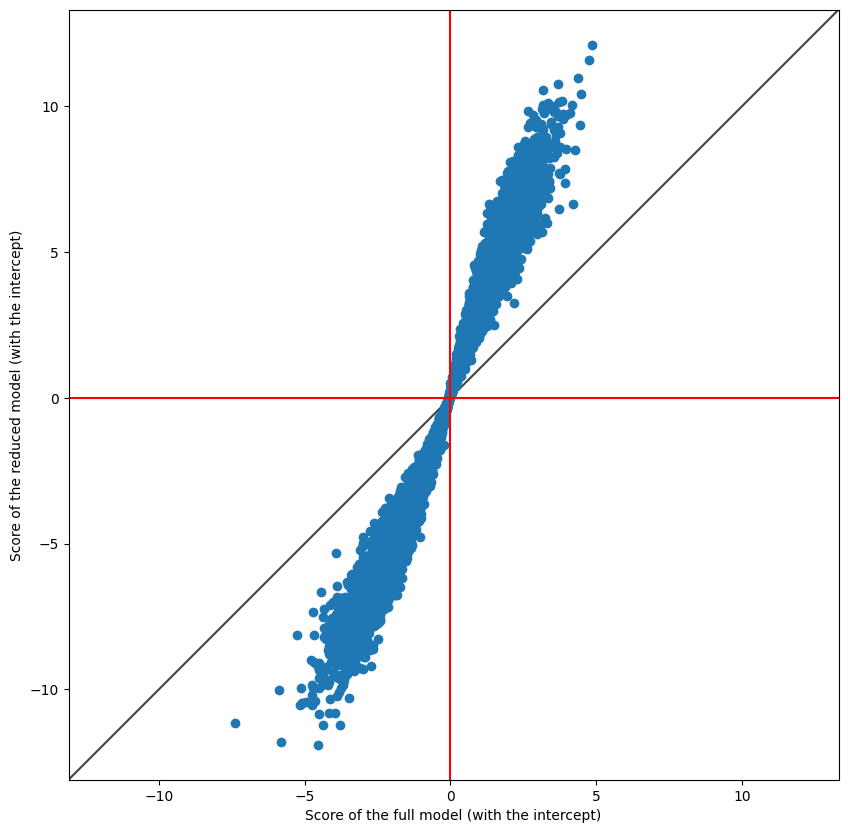

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
x = scores["full"]
y = scores["reduced"]
ax.scatter(x, y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
ax.set_aspect("equal")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Score of the full model (with the intercept)")
ax.set_ylabel("Score of the reduced model (with the intercept)")
ax.axhline(y=0, color="red")
ax.axvline(x=0, color="red")

## (*Appendix) Why is there a difference in the reduced model prediction at all?

### Formula for the full model

Observe that the transformation done by the full model of the text $X$ is the following:
Count occurences of all the n-grams from the full tf-idf vocabulary $T$, that is tf (term frequency) of words:
$$
\left(\text{tf}(i,X)\right)_{i \in T}
$$
Multiply tf by idf (inverse document frequency of the n-gram which is a weight calculated during fitting process, this does not depend on the text $X$):
$$
\left(\text{tf}(i,X)\cdot \text{idf}(i) \right)_{i \in T}
$$
Normalize the obtained vector, that is divide by the norm of the entire vector. This norm depends on all the coordinates corresponding to $T$:
$$
\left( \frac{\text{tf}(i,X)\cdot \text{idf}(i)}{\sqrt{ \sum_{j \in T} (\text{tf}(j,X)\cdot \text{idf}(j) )^{2}}}  \right)_{i \in T}
$$
Select only parts of the vector which where selected by feature selector. Denote this set of n-grams as $S$
$$
\left( \frac{\text{tf}(i,X)\cdot \text{idf}(i)}{\sqrt{ \sum_{j \in T} (\text{tf}(j,X)\cdot \text{idf}(j) )^{2}}}  \right)_{i \in S}
$$
Let us denote the final prediction of the full model for the text $X$ as $P(X)$. It is equal to:
$$
P(X) = 
b + \sum_{i \in S} \text{svc}(i) \cdot 
\left( \frac{\text{tf}(i,X)\cdot \text{idf}(i)}{\sqrt{ \sum_{j \in T} (\text{tf}(j,X)\cdot \text{idf}(j) )^{2}}}  \right),
$$
where $b$ is the intercept.

### Formula for the reduced model

While the transformation of the reduced model is the following:
Count occurences of all the n-grams from the subset $S$, that is tf (term frequency) of words:
$$
\left(\text{tf}(i, X)\right)_{i \in S}
$$
Multiply tf by idf (inverse document frequency of the n-gram which is a weight calculated during fitting process):
$$
\left(\text{tf}(i, X)\cdot \text{idf}(i) \right)_{i \in S}
$$
Normalize the obtained vector. This norm depends on only the coordinates corresponding to $S$:
$$
\left( \frac{\text{tf}(i, X)\cdot \text{idf}(i)}{\sqrt{ \sum_{j \in S} (\text{tf}(j, X)\cdot \text{idf}(j) )^{2}}}  \right)_{i \in S}
$$
The final prediction of the reduced model is equal to:
$$
P_{\text{reduced}}(X) = 
b + \sum_{i \in S} \text{svc}(i) \cdot 
\left( \frac{\text{tf}(i, X)\cdot \text{idf}(i)}{\sqrt{ \sum_{j \in S} (\text{tf}(j, X)\cdot \text{idf}(j) )^{2}}}  \right).
$$

### Can we reconstruct the full prediction from the reduced model?

The subtle, but crucial difference between theses formulas is the set $S$ or $T$ in the denominator.
There is a natural question if we can reconstruct the full prediction from the reduced one. Unfortunately, this is not the case. Indeed, after some transformations, we have:
$$
P(X) = b + \left(P_{\text{reduced}}(X) - b\right) \cdot A(X),
$$
where the factor $A$ is equal to:
$$
A(X) =
\frac{\sqrt{ \sum_{j \in S} (\text{tf}(j, X)\cdot \text{idf}(j) )^{2}}}{\sqrt{ \sum_{j \in T} (\text{tf}(j, X)\cdot \text{idf}(j) )^{2}}} =
\sqrt{1 - \frac{1}{\sum_{j \in T \setminus S} (\text{tf}(j, X)\cdot \text{idf}(j) )^{2}}}.
$$
We cannot calculate $A(X)$ without knowing the full model parameters $(\text{idf}(j))_{j \in T \setminus S}$. And these parameters is precisely the information destroyed during the compression.

### Connection between the formulas and the scatter plot of empirical data

This relationship explains the scatter plot we have seen and why the points seem to lie between the diagonal and the vertical lines. Indeed, we will show below that after omitting the intercept, all the points must be precisely in the sector $\frac{y}{x} \geq 1$.

We have the following:
$$
\frac{P_{\text{reduced}}(X) - b}{P(X) - b} = \frac{1}{A(X)} \geq 1,
$$
because $A(X) \leq 1$.

In [21]:
b = model.pipeline[1].intercept_[0]

In [22]:
scores_full_model = np.array(scores["full"]) - b
scores_reduced_model = np.array(scores["reduced"]) - b

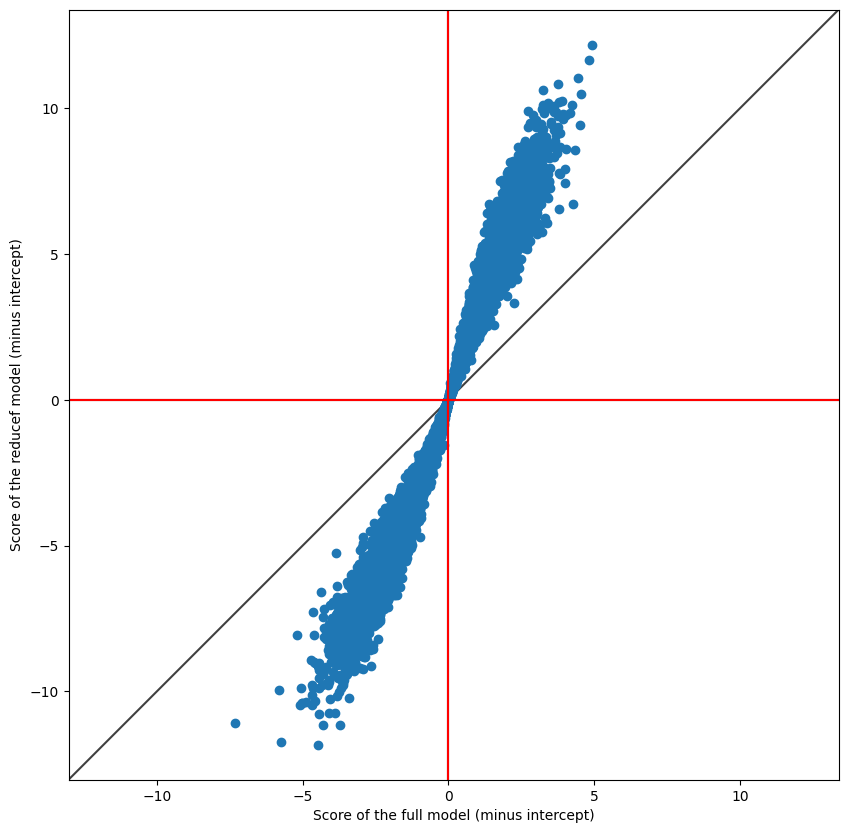

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
x = scores_full_model
y = scores_reduced_model
ax.scatter(x, y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
ax.set_aspect("equal")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Score of the full model (minus intercept)")
ax.set_ylabel("Score of the reducef model (minus intercept)")
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
ax.axhline(y=0, color="red")
ax.axvline(x=0, color="red")

In [24]:
assert sum(y / x <= 1) == 0

This scaling effect is precisely what we can expect from decreasing the normalization factor.

Corollaries:
1. It should be possible to make this model compression lossless by eliminating normalization step or moving it after the feature selection step
1. The same effect can be obtained by training the svc without the intercept